In [9]:
## Python package imports 
import numpy as np
import matplotlib
import scipy.integrate as sint
import matplotlib.pyplot as plt

## respic imports
from rsrespic.fields import fields
from rsrespic.particles import particles
from rsrespic.solvers import solvers
from rsrespic.utilities import constants, diagnostics, utilities

## rsbeams imports
from rsbeams.rsptcls import bunch

## constants 
q = constants.cgs_constants['q']
c = constants.cgs_constants['c']
c_mks = c / 100.
m_e = constants.cgs_constants['m_e']
m_p = constants.cgs_constants['m_p']
pi = np.pi


# Note that this example requires rsbeams

In [15]:
## Particle definitions 
emit = 1.0e-9
charge_per_cm_mks = 1.0e-11
charge_per_meter = charge_per_cm_mks * 100
Q = constants.charge_mks_to_cgs(charge_per_cm_mks)

n_particles = 10000
ds = 0.10
s = 0.0
E = 2.0e6


## This is where we initialize a KV distribuiton
newKVBunch = bunch.StandardBunch(n_particles, dist='KV', emitx = emit, emity = emit)
newKVBunch.set_longitudinal_coordinates(dpop=0.00) #here we reset the dpop value
newKVBunch.set_transverse_coordinates()

new_distribution = particles.distribution()
new_distribution.type = 'KV'
new_distribution.e_x = newKVBunch.emitx
new_distribution.e_y = newKVBunch.emity
new_distribution.N = newKVBunch.npart
new_distribution.x = newKVBunch.particles[:,0] * 100.
new_distribution.xp = newKVBunch.particles[:,1]
new_distribution.y = newKVBunch.particles[:,2] * 100.
new_distribution.yp = newKVBunch.particles[:,3]
new_distribution.z = newKVBunch.particles[:,4]
new_distribution.pz = newKVBunch.particles[:,5]

sigma_x = np.max(np.sqrt(new_distribution.x**2 + new_distribution.y**2))


## Particle distributions
my_kv_beam = particles.particles_2D_delta(new_distribution, # dx_tent = 1 * L_min, dy_tent = 1 * L_min, 
    bunch_charge = Q, species_charge = q, species_mass = m_e, K_e = E)


## Define the fields 
#L_0 = 5. * sigma_x ## Half the domain size
#L_min = L_0 / 10. ## minimum wavelength to resolve

#my_fields = fields.cartesian_2D(L_x = L_0, L_y = L_0,
#    L_x_min = L_min, L_y_min = L_min)

## This is where we instantiate the solver
#field_solver = solvers.field_solver_2D()
#my_fields.register_solver(field_solver)



## Define the fields using sin transform
k = 10
N_s = 1 * k
L_s = N_s * sigma_x
n_x = 10 * k
n_y = 10 * k

my_fields = fields.sin_transform_2D(L_x = L_s, L_y = L_s, 
                        n_modes_x = n_x, n_modes_y = n_y)

## This is where we instantiate the solver
field_solver = solvers.sine_transform_2D()
my_fields.register_solver(field_solver)



## instantiate the diagnostics 
ptcl_diag = diagnostics.bunch_statistics()


In [16]:
## Load the maps and define the stepper
maps = solvers.symplectic_maps()

## Define steppers
def step(particles, fields, ds = ds):
    maps.drift(particles, ds = ds / 2.)
    maps.space_charge_kick_2D_sine(fields, particles, ds = ds)
    maps.drift(particles, ds = ds / 2.)


In [17]:
## Here we run the simulation, 1000 steps using the stepper functions defined in the previous block
ptcl_diag.update(s, my_kv_beam)

k = 0

while k < 100:

    step(my_kv_beam, my_fields)
    
    s = s + ds
    
    ptcl_diag.update(s, my_kv_beam)
        
    k = k + 1

In [18]:
## Compute analytic expansion for benchmarkiung. 

current = my_kv_beam.beta * c_mks * charge_per_meter

s_array = ptcl_diag.get_parameter('s') / 100.

r_analyitic = utilities.round_beam_expansion(s_array, 2. * newKVBunch.emit, sigma_x/100.,
        current, my_kv_beam.gamma, my_kv_beam.m_0)

r_zero_current = utilities.round_beam_expansion(s_array, 2. * newKVBunch.emit, sigma_x/100.,
        0.0, my_kv_beam.gamma, my_kv_beam.m_0)


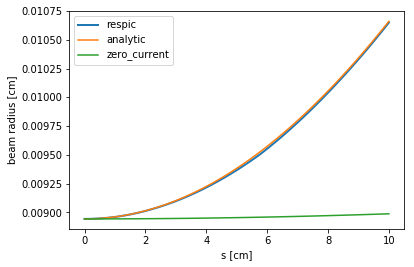

In [19]:
## Plotting 

x_key = 's'
y_key = 'r_beam'

plt.figure()
ptcl_diag.plot(x_key, y_key)
plt.plot(s_array * 100, r_analyitic[:,0] * 100.)
plt.plot(s_array * 100, r_zero_current[:,0] * 100.)
plt.xlabel('s [cm]')
plt.ylabel('beam radius [cm]')
plt.legend(['respic', 'analytic', 'zero_current'])
plt.savefig('respic_benchmark_kv.pdf')

plt.show()



In [7]:
current

0.2935190362385341

In [8]:
newKVBunch.emit

4e-09